<a href="https://colab.research.google.com/github/MohammadYehya/SegmentAnythingModel_SAM/blob/main/SAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --quiet git+https://github.com/facebookresearch/segment-anything.git

  Preparing metadata (setup.py) ... done


In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
from segment_anything import sam_model_registry, SamPredictor, SamAutomaticMaskGenerator
from huggingface_hub import hf_hub_download

In [3]:
def download_checkpoint(model_name: str, dest_path: str) -> str:
    if os.path.isfile(dest_path):
        print(f"Using existing checkpoint at {dest_path}")
        return dest_path
    print("Downloading checkpoint from remote (Hugging Face Hub)... this may take a while (~GB)")
    local_path = hf_hub_download(repo_id="ybelkada/segment-anything",
                                 filename=os.path.join("checkpoints", model_name))
    print(f"Downloaded checkpoint to {local_path}")
    return local_path

In [4]:
def load_image(image_path):
    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"Could not read image: {image_path}")
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

In [5]:
def show_mask_on_image(image, mask, alpha=0.5, color=(0, 255, 0)):
    colored = image.copy()
    mask_bool = mask.astype(bool)
    colored[mask_bool] = (np.array(color) * alpha + colored[mask_bool] * (1 - alpha)).astype(np.uint8)
    return colored

In [6]:
# Configuration
model_variant = "vit_b"  # choose from: vit_b, vit_l, vit_h
ckpt_map = {
    "vit_b": "sam_vit_b_01ec64.pth",
    "vit_l": "sam_vit_l_0b3195.pth",
    "vit_h": "sam_vit_h_4b8939.pth"
}
ckpt_filename = ckpt_map[model_variant]
os.makedirs("checkpoints", exist_ok=True)
checkpoint_path = download_checkpoint(ckpt_filename, os.path.join("checkpoints", ckpt_filename))


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


checkpoints/sam_vit_b_01ec64.pth:   0%|          | 0.00/375M [00:00<?, ?B/s]

Downloaded checkpoint to /root/.cache/huggingface/hub/models--ybelkada--segment-anything/snapshots/7790786db131bcdc639f24a915d9f2c331d843ee/checkpoints/sam_vit_b_01ec64.pth


In [7]:
# Load model
sam = sam_model_registry[model_variant](checkpoint=checkpoint_path)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
sam = sam.to(device)
predictor = SamPredictor(sam)


In [8]:
# Upload image (Colab) or load locally
from google.colab import files
uploaded = files.upload()
img_path = list(uploaded.keys())[0]
image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
print("Loaded image", img_path, "shape", image.shape)
predictor.set_image(image)

Saving test2.jpg to test2.jpg
Loaded image test2.jpg shape (300, 450, 3)


Got 3 mask(s). First mask score: 0.9396784


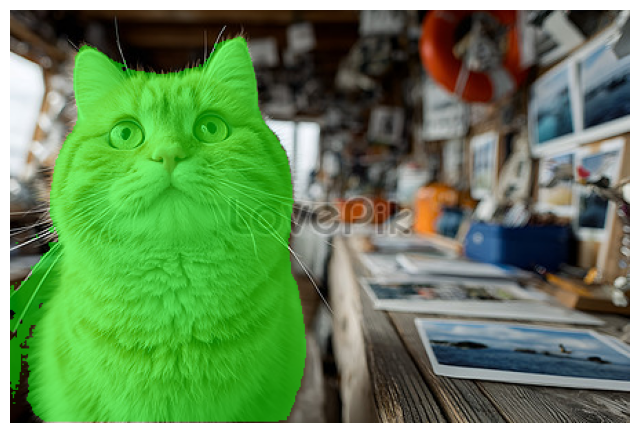

In [9]:
# --- Example: Segment with a point prompt ---
# Define a point (x, y) you want to segment
input_point = np.array([[100, 100]])  # modify as needed
input_label = np.array([1])  # 1 for foreground

masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)

print("Got", len(masks), "mask(s). First mask score:", scores[0])
overlay = show_mask_on_image(image, masks[0])
plt.figure(figsize=(8,8))
plt.imshow(overlay)
plt.axis('off')
plt.show()

Generated 72 masks


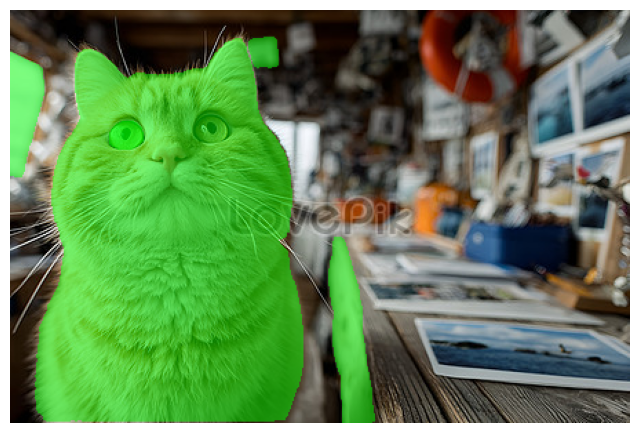

In [10]:
# --- Example: Automatic mask generation (whole image) ---
mask_generator = SamAutomaticMaskGenerator(sam)
masks = mask_generator.generate(image)
print(f"Generated {len(masks)} masks")
overlay = image.copy()
for m in masks[:5]:
    mask = m["segmentation"]
    overlay = show_mask_on_image(overlay, mask, alpha=0.5, color=(0,255,0))
plt.figure(figsize=(8,8))
plt.imshow(overlay)
plt.axis('off')
plt.show()